In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

In [2]:
devkit_path = Path('../input/car_devkit/devkit')
train_path = Path('../input/cars_train/cars_train')
test_path = Path('../input/cars_test/cars_test')

# DevKit

In [3]:
os.listdir(devkit_path)

['eval_train.m',
 'cars_test_annos.mat',
 'README.txt',
 'train_perfect_preds.txt',
 'cars_meta.mat',
 'cars_train_annos.mat']

## `README.txt`

```
This file gives documentation for the cars 196 dataset.
(http://ai.stanford.edu/~jkrause/cars/car_dataset.html)

----------------------------------------
Metadata/Annotations
----------------------------------------
Descriptions of the files are as follows:

-cars_meta.mat:
  Contains a cell array of class names, one for each class.

-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.

-cars_test_annos.mat:
  Same format as 'cars_train_annos.mat', except the class is not provided.
```

From the `README.txt` file, we have the three meta data filles oppened bellow

In [4]:
#cars_meta = loadmat(devkit_path/'cars_meta.mat')
#print(cars_meta['class_names'][0])


[array(['AM General Hummer SUV 2000'], dtype='<U26')
 array(['Acura RL Sedan 2012'], dtype='<U19')
 array(['Acura TL Sedan 2012'], dtype='<U19')
 array(['Acura TL Type-S 2008'], dtype='<U20')
 array(['Acura TSX Sedan 2012'], dtype='<U20')
 array(['Acura Integra Type R 2001'], dtype='<U25')
 array(['Acura ZDX Hatchback 2012'], dtype='<U24')
 array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40')
 array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34')
 array(['Aston Martin Virage Convertible 2012'], dtype='<U36')
 array(['Aston Martin Virage Coupe 2012'], dtype='<U30')
 array(['Audi RS 4 Convertible 2008'], dtype='<U26')
 array(['Audi A5 Coupe 2012'], dtype='<U18')
 array(['Audi TTS Coupe 2012'], dtype='<U19')
 array(['Audi R8 Coupe 2012'], dtype='<U18')
 array(['Audi V8 Sedan 1994'], dtype='<U18')
 array(['Audi 100 Sedan 1994'], dtype='<U19')
 array(['Audi 100 Wagon 1994'], dtype='<U19')
 array(['Audi TT Hatchback 2011'], dtype='<U22')
 array(['Audi S6 Sedan 2011'], dtyp

In [3]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos.mat')

## Loading Labels

In [4]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


## Loading Cars Train

In [5]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,../input/cars_train/cars_train/00001.jpg
1,36,116,868,587,2,../input/cars_train/cars_train/00002.jpg
2,85,109,601,381,90,../input/cars_train/cars_train/00003.jpg
3,621,393,1484,1096,133,../input/cars_train/cars_train/00004.jpg
4,14,36,133,99,105,../input/cars_train/cars_train/00005.jpg


### Merging labels

In [6]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,../input/cars_train/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,../input/cars_train/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,../input/cars_train/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,../input/cars_train/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,../input/cars_train/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


## Loading Cars Test

In [76]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path/f for f in df_test['fname']] #  Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,../input/cars_test/cars_test/00001.jpg
1,100,19,576,203,../input/cars_test/cars_test/00002.jpg
2,51,105,968,659,../input/cars_test/cars_test/00003.jpg
3,67,84,581,407,../input/cars_test/cars_test/00004.jpg
4,140,151,593,339,../input/cars_test/cars_test/00005.jpg


## Displaying Image

In [42]:

import os
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from collections import Counter
import random
from tqdm import tqdm  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import cv2

In [79]:
# Root dataset directory 
ROOT_DIR = '/kaggle/input/stanford-cars-dataset/cars_train'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
CROPPED_DIR = '/kaggle/working/cropped__images'

# crop train
def get_assets(df, i):
    os.makedirs(CROPPED_DIR , exist_ok=True)
    #is_train = df is df_train
    #folder = train_path if is_train else test_path
    image = plt.imread(df['fname'][i])
    img_name = filename = os.path.basename(df['fname'][i])
    #title = df['labels'][i] if is_train else 'Unclassified'
    

    #src_path = os.path.join(IMAGE_DIR, df_train['fname'][i])
    dst_path = os.path.join(CROPPED_DIR, df['labels'][i])
    #dst_folder = os.path.dirname(dst_path)
    os.makedirs(dst_path, exist_ok=True)


    x = df['bbox_x1'][i]
    y = df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    #rect = Rectangle(x , y, width, height, fill=False, color='r', linewidth=2)
    x, y, w, h = map(int, [x, y, width, height])
    crop = image[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dst_path, img_name), crop)
    
    
    #return (image, title)



In [81]:
for img_path in range(len(df_train)):
    get_assets(df_train, img_path)

In [82]:
folder_path = '/kaggle/working/cropped__images'

# List all files and folders
contents = os.listdir(folder_path)
print(contents)

['Chevrolet Express Van 2007', 'Bentley Continental Supersports Conv. Convertible 2012', 'Audi V8 Sedan 1994', 'Audi TTS Coupe 2012', 'Bentley Arnage Sedan 2009', 'Chrysler Town and Country Minivan 2012', 'Rolls-Royce Ghost Sedan 2012', 'Chevrolet Impala Sedan 2007', 'Hyundai Azera Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW M5 Sedan 2010', 'Maybach Landaulet Convertible 2012', 'BMW X5 SUV 2007', 'Audi 100 Wagon 1994', 'Dodge Caliber Wagon 2012', 'Volkswagen Golf Hatchback 2012', 'Spyker C8 Coupe 2009', 'Lamborghini Reventon Coupe 2008', 'AM General Hummer SUV 2000', 'Hyundai Elantra Sedan 2007', 'Chrysler Crossfire Convertible 2008', 'Rolls-Royce Phantom Sedan 2012', 'Chevrolet Silverado 1500 Regular Cab 2012', 'Aston Martin V8 Vantage Convertible 2012', 'GMC Terrain SUV 2012', 'BMW M6 Convertible 2010', 'Buick Regal GS 2012', 'Mercedes-Benz Sprinter Van 2012', 'Hyundai Santa Fe SUV 2012', 'Ford F-150 Regular Cab 2012', 'Chevrolet Malibu Sedan 2007', 'Cadillac CTS-V Sedan 2012', 'Ast

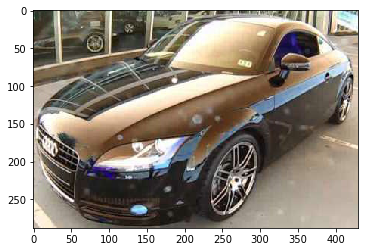

In [83]:
img = plt.imread('/kaggle/working/cropped__images/Audi TTS Coupe 2012/02007.jpg')
plt.imshow(img)

In [85]:
# Root dataset directory 
ROOT_DIR = '/kaggle/input/stanford-cars-dataset/cars_test'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
CROPPED_DIR = '/kaggle/working/cropped__images__test'

# crop train
def get_assets(df, i):
    os.makedirs(CROPPED_DIR , exist_ok=True)
    is_test = df is df_test
    #folder = test_path if is_train else test_path
    image = plt.imread(df['fname'][i])
    img_name = filename = os.path.basename(df['fname'][i])
    #title = df['labels'][i] if is_test else 'Unclassified'
    

    #src_path = os.path.join(IMAGE_DIR, df_train['fname'][i])
    dst_path = os.path.join(CROPPED_DIR, "test")
    #dst_folder = os.path.dirname(dst_path)
    os.makedirs(dst_path, exist_ok=True)


    x = df['bbox_x1'][i]
    y = df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    #rect = Rectangle(x , y, width, height, fill=False, color='r', linewidth=2)
    x, y, w, h = map(int, [x, y, width, height])
    crop = image[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dst_path, img_name), crop)
    
    
    #return (image, title)


In [86]:
for img_path in range(len(df_test)):
    get_assets(df_test, img_path)

In [88]:
folder_path = '/kaggle/working/cropped__images__test/test'

# List all files and folders
contents = os.listdir(folder_path)
print(contents)

['01099.jpg', '00532.jpg', '04742.jpg', '04454.jpg', '08026.jpg', '05513.jpg', '05615.jpg', '03045.jpg', '03898.jpg', '05462.jpg', '05347.jpg', '04166.jpg', '00981.jpg', '02011.jpg', '04783.jpg', '05085.jpg', '06237.jpg', '01122.jpg', '07403.jpg', '05833.jpg', '00826.jpg', '04817.jpg', '05014.jpg', '01783.jpg', '00137.jpg', '00899.jpg', '06276.jpg', '04807.jpg', '01257.jpg', '03086.jpg', '00793.jpg', '02455.jpg', '00748.jpg', '04731.jpg', '07473.jpg', '03584.jpg', '04052.jpg', '03548.jpg', '01025.jpg', '00280.jpg', '05759.jpg', '07952.jpg', '00879.jpg', '06359.jpg', '04023.jpg', '00805.jpg', '02661.jpg', '06478.jpg', '04250.jpg', '00122.jpg', '03588.jpg', '02120.jpg', '07454.jpg', '01376.jpg', '05390.jpg', '03933.jpg', '07164.jpg', '00178.jpg', '07167.jpg', '00266.jpg', '02205.jpg', '07742.jpg', '07200.jpg', '01009.jpg', '04172.jpg', '06636.jpg', '02829.jpg', '06697.jpg', '04662.jpg', '04996.jpg', '06402.jpg', '03856.jpg', '03629.jpg', '04401.jpg', '04203.jpg', '07215.jpg', '01460.jpg'

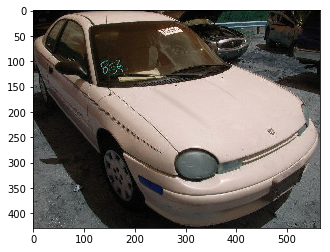

In [89]:
img = plt.imread('/kaggle/working/cropped__images__test/test/07159.jpg')
plt.imshow(img)

In [91]:
#Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Path to the new dataset
data_dir = '/kaggle/working/cropped__images'

# Transform for resizing and normalizing images for ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load the tain dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(full_dataset.classes)

# Total number of data samples
total_size = len(full_dataset)

# Split data into 80-20 ratio (train + validation)
train_size = int(0.8 * total_size)  


test_dir = '/kaggle/working/cropped__images__test/test' # adjust path if needed

# Count only .jpg files
test_size = len([f for f in os.listdir(test_dir) if f.endswith('.jpg')])


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# DataLoader for each part of the dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display dataset information
print(f'Total Classes: {num_classes}')
print(f'Total Samples: {total_size}')
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')


Using device: cpu
Total Classes: 196
Total Samples: 8144
Train size: 6515
Validation size: 1629
Test size: 8041


In [92]:
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=200, dropout_rate=0.6):
        super(BilinearCNN, self).__init__()
        
        # Load the pre-trained ResNet50 model
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make only the last layer (layer4) trainable
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        
        self.features = nn.Sequential(*list(backbone.children())[:-2])  
        # Reduce the dimension to 512
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1)
        # Dropout 
        self.dropout = nn.Dropout(p=dropout_rate)
        # Fully connected 
        self.fc = nn.Linear(512 * 512, num_classes)

    def forward(self, x):
        
        x = self.features(x)          
       
        x = self.reduce_dim(x)        
       
        x = x.view(x.size(0), 512, -1)  
        
        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2)  
        
        x = x.view(x.size(0), -1)  
        
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
       
        x = nn.functional.normalize(x)
        
        x = self.dropout(x)
        
        x = self.fc(x)
        return x

# Create the model and move it to the GPU if available
model = BilinearCNN(num_classes=num_classes).to(device)

# Loss function, Optimizer, and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)  

# Early Stopping Class to stop training if validation loss doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience  
        self.min_delta = min_delta  
        self.counter = 0  
        self.best_loss = None  
        self.early_stop = False  

    def __call__(self, val_loss):
        # If the current validation loss is better than the best, reset the counter
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            # If no improvement, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exhausted

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training the model
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"⛔ Early stopping at epoch {epoch+1}")
        break

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth


ConnectionError: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /models/resnet50-19c8e357.pth (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x78d3441b1588>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

In [ ]:
def evaluate_model(model, dataloader, dataset_name):
    model.eval()  
    all_preds = [] 
    all_labels = []  
    top5_preds = []  

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, preds = torch.max(outputs, 1)  

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)  

            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    #Calculate Metrics
    acc = accuracy_score(all_labels, all_preds) 
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)  
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)  
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)  
    
    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy 
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print performance metrics
    print(f"\n Performance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)  
    plt.figure(figsize=(12, 10)) 
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',  
                xticklabels=full_dataset.classes[:20],
                yticklabels=full_dataset.classes[:20])
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")  
    plt.xlabel("Predicted")  
    plt.ylabel("Actual")  
    plt.show()  

# Evaluate on the Validation set
evaluate_model(model, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model, test_loader, "Test")

## Displaying Range Image

In [ ]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
    plt.show()

In [ ]:
display_range(5)

## Cars' Distribution

In [60]:
freq_labels = df_train.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

,count
labels,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


In [ ]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");